# Key Point: Conv2D and ConvLSTM2D
反正用了哪些技术，你自己看  
  
480 240 120 三个你一起看  
我跑了三个模型都放在 Models 里面，来比较哪个好用

记得提到，模型不一样，因为图片分辨率不同消耗的计算资源也不同，所以在最大的限度使用我们组的 GPU 设备 RTX4070 Super 显卡的算力情况下，对于分辨率越低的方案，我们就使用越复杂的模型，增加卷积层层数之类的，反正你自己看，Report 多说多做就是了。  
|  
|  
|     
|  
|       
# 然后这是为什么选择 480 的原因

下面是 GPT 给的,你要参考最后的预测的 cell,三个文件

在评估图像预测效果时，不同分辨率的图像有不同的表现，具体取决于所关注的指标。以下是三个主要评估指标的分析：  

1. 均方误差（MSE）  
解释：MSE 衡量的是预测值与实际值的平方差的平均值，数值越小，说明预测结果与真实值越接近。  
结果：  
120×120 分辨率下 MSE：0.0209  
240×240 分辨率下 MSE：0.0269  
480×480 分辨率下 MSE：0.0365  
分析：120×120 的分辨率有最低的 MSE，表明在该分辨率下模型的预测与真实值之间的误差最小。  
2. 平均绝对误差（MAE）  
解释：MAE 衡量的是预测值与实际值的绝对差的平均值，数值越小越好。  
结果：  
120×120 分辨率下 MAE：0.0741  
240×240 分辨率下 MAE：0.0922  
480×480 分辨率下 MAE：0.1211  
分析：120×120 分辨率的 MAE 最低，表明在该分辨率下预测值与实际值的偏差最小。  
3. 结构相似性（SSIM）  
解释：SSIM 衡量预测图像与真实图像在结构、亮度和对比度上的相似性，值越接近 1，表示结构上越相似。  
结果：  
120×120 分辨率下 SSIM：0.3247  
240×240 分辨率下 SSIM：0.1206  
480×480 分辨率下 SSIM：0.0253  
分析：120×120 分辨率的 SSIM 值最高，表明它在结构上比其他分辨率的预测更接近真实图像。  
结论与推荐标准  
推荐标准：根据 MSE、MAE 和 SSIM 的结果来看，120×120 分辨率下的预测效果在所有指标上都表现最佳。因此，可以选择 MSE 和 SSIM 作为综合标准，分别衡量预测值的准确性和结构上的相似性。  
选择 120×120 分辨率的原因：  
该分辨率下，MSE 和 MAE 都最小，表明其数值误差较低。  
SSIM 值最高，意味着图像的结构保真度较好，尤其在空间特征损失较少的情况下，可以更好地还原图像的结构特性。  

# 但是最终我选择了 480

从上面的对比来看：  

120x120 分辨率：预测结果模糊，尤其是对于小的结构细节不够清晰。这种情况符合预期，因为较低的分辨率限制了模型捕捉精细特征的能力。  

240x240 分辨率：相比 120x120 分辨率，这个分辨率的预测图像在清晰度和结构上有所改善。尽管还有一些模糊，但整体的形状和区域分布比低分辨率时更清晰。  

480x480 分辨率：在最高分辨率（480x480）下，预测结果具有最好的细节呈现效果，边界更加锐利。这让预测结果在视觉上更接近实际图像。然而，由于高分辨率模型对变化的敏感度更高，可能也会引入一些噪声或伪影。  

选择哪个分辨率以及原因  
如果您的主要目标是获得更高的结构相似性（SSIM）和视觉清晰度，那么480x480 分辨率模型更具优势。虽然它的均方误差（MSE）和平均绝对误差（MAE）可能稍高一些，但在视觉保真度和细节还原上效果更好，因此在需要较高细节保留的场景中更为可靠。  

In [1]:
import os
import cv2
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt

# 输入文件夹路径
input_folder = './dataOneDay'

# 初始化列表来存放原始和处理后的图片
original_images = []
processed_images = []

# 设置最小降雨面积阈值
min_rain_area = 10  # 可根据需要调整

# 遍历文件夹中的每张图片
for filename in sorted(os.listdir(input_folder)):
    # 检查是否为图片文件
    if filename.endswith('.png'):
        input_path = os.path.join(input_folder, filename)
        
        # Step 1: 读取图片
        img = cv2.imread(input_path)
        if img is None:
            print(f"Error: 图片 {filename} 未成功加载，跳过此文件。")
            continue
        
        # Step 2: 灰度化处理
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Step 3: 保存未处理的灰度图像到 original_images
        original_images.append(gray_img)
        
        # Step 4: 二值化处理
        _, binary_img = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)
        
        # Step 5: 去除小面积区域
        binary_img = morphology.remove_small_objects(binary_img.astype(bool), min_rain_area)
        binary_img = (binary_img * 255).astype(np.uint8)
        
        # Step 6: 应用掩码
        processed_img = cv2.bitwise_and(gray_img, gray_img, mask=binary_img)
        
        # Step 7: 归一化
        normalized_img = (processed_img / 255.0)  # 归一化到 0-1 区间
        
        # 将处理后的图像添加到 processed_images
        processed_images.append(normalized_img)

print("图片处理完成。`original_images` 和 `processed_images` 数据已准备好。")


图片处理完成。`original_images` 和 `processed_images` 数据已准备好。


记得讲 滑动窗口生成，因为我们的图片有顺序，而且和时间相关  
还有 模型 Summary 输出的内容也是可以对比的

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, TimeDistributed, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

# 假设 processed_images 已经准备好，每个图像大小为 (480, 480)
processed_images = np.array(processed_images)  # 转换成 NumPy 数组
processed_images = processed_images[..., np.newaxis]  # 添加单通道 (480, 480) -> (480, 480, 1)

time_steps = 12  # 输入时间步
pred_steps = 12  # 预测时间步

# 优化后的滑动窗口生成输入-输出对
num_samples = len(processed_images) - time_steps - pred_steps + 1
X = np.array([processed_images[i:i + time_steps] for i in range(num_samples)])
y = np.array([processed_images[i + time_steps:i + time_steps + pred_steps] for i in range(num_samples)])

print("X shape:", X.shape)  # (num_samples, time_steps, 480, 480, 1)
print("y shape:", y.shape)  # (num_samples, pred_steps, 480, 480, 1)

# 数据集划分
train_ratio = 0.8
split_index = int(train_ratio * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

X shape: (265, 12, 480, 480, 1)
y shape: (265, 12, 480, 480, 1)
Training data shape: (212, 12, 480, 480, 1) (212, 12, 480, 480, 1)
Validation data shape: (53, 12, 480, 480, 1) (53, 12, 480, 480, 1)


In [3]:
# 模型构建
def build_rainfall_prediction_model(time_steps, pred_steps, input_shape=(480, 480, 1)):
    model = Sequential()
    
    # 提取空间特征的 Conv2D 层，通过 TimeDistributed 应用到每个时间步
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(time_steps, *input_shape)))
    model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(Dropout(0.3)))

    # 提取时间动态的 ConvLSTM2D 层
    model.add(ConvLSTM2D(8, (3, 3), padding='same', return_sequences=True))
    model.add(ConvLSTM2D(8, (3, 3), padding='same', return_sequences=True))
    
    # 将输出映射到单通道输出，预测降雨分布
    model.add(TimeDistributed(Conv2D(1, (3, 3), activation='sigmoid', padding='same')))
    model.add(Reshape((pred_steps, input_shape[0], input_shape[1], 1)))  # 调整 Reshape 层
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    
    return model


model = build_rainfall_prediction_model(time_steps, pred_steps)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 12, 480, 480, 32)  320      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 480, 480, 16)  4624     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 12, 480, 480, 16)  0        
 tributed)                                                       
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 12, 480, 480, 8)   6944      
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 12, 480, 480, 8)   4640      
                                                        

In [4]:
import tensorflow as tf

# 检查可用的 GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
else:
    print("No GPU detected.")


GPU is available.


In [5]:
# 训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=1  # 调整 batch_size 以适应显存大小
)

Epoch 1/10
212/212 [==============================] - 56s 225ms/step - loss: 0.1159 - val_loss: 0.0560
Epoch 2/10
212/212 [==============================] - 45s 211ms/step - loss: 0.0580 - val_loss: 0.0299
Epoch 3/10
212/212 [==============================] - 45s 212ms/step - loss: 0.0488 - val_loss: 0.0232
Epoch 4/10
212/212 [==============================] - 45s 212ms/step - loss: 0.0460 - val_loss: 0.0231
Epoch 5/10
212/212 [==============================] - 45s 213ms/step - loss: 0.0445 - val_loss: 0.0210
Epoch 6/10
212/212 [==============================] - 45s 211ms/step - loss: 0.0436 - val_loss: 0.0212
Epoch 7/10
212/212 [==============================] - 45s 211ms/step - loss: 0.0430 - val_loss: 0.0199
Epoch 8/10
212/212 [==============================] - 45s 211ms/step - loss: 0.0424 - val_loss: 0.0192
Epoch 9/10
212/212 [==============================] - 45s 213ms/step - loss: 0.0421 - val_loss: 0.0192
Epoch 10/10
212/212 [==============================] - 45s 210ms/step - l

X_test shape: (1, 12, 480, 480, 1)
y_actual shape: (1, 12, 480, 480, 1)
1/1 [==============================] - 0s 242ms/step
Mean Squared Error (MSE) on Test Set: 0.036532390138940635
Mean Absolute Error (MAE) on Test Set: 0.12114593512298528
Mean Structural Similarity (SSIM) on Test Set: 0.02526635260813223


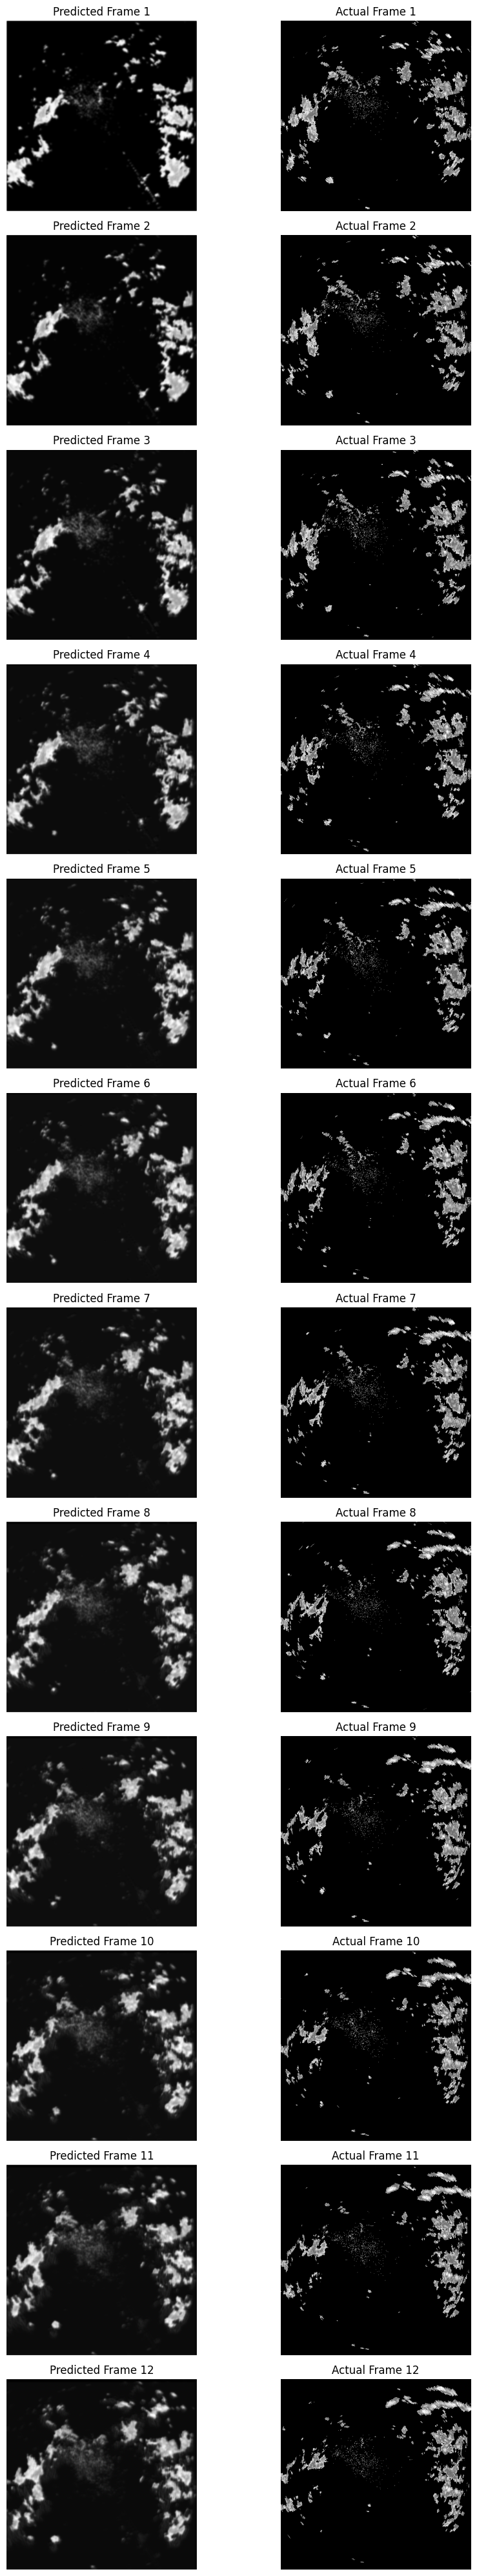

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim

# 文件夹路径
test_folder = './dataOneDayTest'
time_steps = 12
pred_steps = 12

# 加载测试图像数据并预处理
test_images = []
image_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.png')])
for file in image_files:
    img = cv2.imread(os.path.join(test_folder, file), cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (480, 480), interpolation=cv2.INTER_AREA)
    normalized_img = resized_img / 255.0  # 归一化
    test_images.append(normalized_img)

# 转换成 NumPy 数组并添加通道维度
test_images = np.array(test_images)[..., np.newaxis]  # 形状: (24, 480, 480, 1)

# 准备测试输入数据
X_test = np.array([test_images[i:i + time_steps] for i in range(len(test_images) - time_steps - pred_steps + 1)])
y_actual = np.array([test_images[i + time_steps:i + time_steps + pred_steps] for i in range(len(test_images) - time_steps - pred_steps + 1)])

print("X_test shape:", X_test.shape)  # (num_samples, time_steps, 480, 480, 1)
print("y_actual shape:", y_actual.shape)  # (num_samples, pred_steps, 480, 480, 1)

# 使用模型进行预测
y_pred = model.predict(X_test)

# 计算 MSE, MAE 和 SSIM
mse = mean_squared_error(y_actual.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_actual.flatten(), y_pred.flatten())

# 计算结构相似性（SSIM）
ssim_scores = []
for i in range(pred_steps):
    ssim_score = ssim(y_actual[0, i, :, :, 0], y_pred[0, i, :, :, 0], data_range=1.0)
    ssim_scores.append(ssim_score)
mean_ssim = np.mean(ssim_scores)

# 输出评估指标
print(f"Mean Squared Error (MSE) on Test Set: {mse}")
print(f"Mean Absolute Error (MAE) on Test Set: {mae}")
print(f"Mean Structural Similarity (SSIM) on Test Set: {mean_ssim}")

# 可视化前几个预测和实际结果的对比
fig, axs = plt.subplots(12, 2, figsize=(10, 40))
for i in range(12):
    # 显示预测结果
    axs[i, 0].imshow(y_pred[0, i, :, :, 0], cmap='gray')
    axs[i, 0].set_title(f"Predicted Frame {i+1}")
    axs[i, 0].axis('off')
    
    # 显示实际结果
    axs[i, 1].imshow(y_actual[0, i, :, :, 0], cmap='gray')
    axs[i, 1].set_title(f"Actual Frame {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [7]:
model.save('Models/SP480.h5')